# State Farm Distracted Driver Detection


[State Farm Distracted Driver Detection](https://www.kaggle.com/c/state-farm-distracted-driver-detection#evaluation)

## Action Plan
### 1. Data Preparation and Preprocessing
### 2. Finetune and Train Model
### 2b. Data Augmentation parameter tuning
### 3. Generate and Validate Predictions 
### 4. Submit predictions to Kaggle

# 2. Finetune and Train Model

## Setup 

In [1]:
%cd "~/kaggle/state-farm-driver-detection/code"
%pwd

/home/ubuntu/kaggle/state-farm-driver-detection/code


'/home/ubuntu/kaggle/state-farm-driver-detection/code'

In [2]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
CODE_HOME_DIR = current_dir
DATA_HOME_DIR = CODE_HOME_DIR + '/../input/'
print(CODE_HOME_DIR)
print(DATA_HOME_DIR)

/home/ubuntu/kaggle/state-farm-driver-detection/code
/home/ubuntu/kaggle/state-farm-driver-detection/code/../input/


In [3]:
#import modules
#from importlib import reload

import utils
from utils import *

import vgg16bn_ted
from vgg16bn_ted import Vgg16BN; 

%matplotlib inline

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Setup Paths

In [4]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' # + '/sample/' 
results_path = path + 'results/'
train_path = path + 'train/'
valid_path = path + 'valid/'
test_path = path + 'test/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.makedirs(model_path)
    
batch_size = 64

/home/ubuntu/kaggle/state-farm-driver-detection/input


#### Setup and save Data Classes, Labels, and Filenames

In [5]:
(trn_classes, val_classes, trn_labels, val_labels, trn_filenames, val_filenames, test_filenames) = get_classes(path)

Found 17940 images belonging to 10 classes.
Found 4484 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [6]:
trn_data = load_array(results_path+'trn_data.bc')
val_data = load_array(results_path+'val_data.bc')

<font color='red'><b>[Warning] Get test_date will cause Memory Error because too big data </b></font>

## Method 1: First training by full Vgg model

In [5]:
vgg = Vgg16BN(size=(256, 256))
#vgg = Vgg16BN()

In [6]:
batch_size=64

In [7]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, shuffle=False, batch_size=batch_size)
vgg.finetune(batches)

Found 17940 images belonging to 10 classes.
Found 4484 images belonging to 10 classes.


#### Model Tuning

In [9]:
vgg.fit(batches, val_batches, epochs=2)

Epoch 1/2
 - 346s - loss: 1.1656 - acc: 0.6431 - val_loss: 0.1348 - val_acc: 0.9674
Epoch 2/2
 - 337s - loss: 0.4400 - acc: 0.8605 - val_loss: 0.0854 - val_acc: 0.9784


In [10]:
model.optimizer.lr = 0.01

In [11]:
vgg.fit(batches, val_batches, epochs=5)

Epoch 1/5
 - 336s - loss: 0.3565 - acc: 0.8824 - val_loss: 0.0634 - val_acc: 0.9837
Epoch 2/5
 - 337s - loss: 0.3394 - acc: 0.8917 - val_loss: 0.0738 - val_acc: 0.9804
Epoch 3/5
 - 337s - loss: 0.3223 - acc: 0.8993 - val_loss: 0.0566 - val_acc: 0.9855
Epoch 4/5
 - 337s - loss: 0.3240 - acc: 0.8959 - val_loss: 0.0637 - val_acc: 0.9819
Epoch 5/5
 - 337s - loss: 0.3366 - acc: 0.8988 - val_loss: 0.0529 - val_acc: 0.9868


In [9]:
model.optimizer.lr = 0.001

In [10]:
vgg.fit(batches, val_batches, epochs=10)

Epoch 1/5
 - 337s - loss: 0.3501 - acc: 0.8957 - val_loss: 0.0541 - val_acc: 0.9853
Epoch 2/5
 - 328s - loss: 0.3587 - acc: 0.8964 - val_loss: 0.0535 - val_acc: 0.9857
Epoch 3/5
 - 328s - loss: 0.3578 - acc: 0.9004 - val_loss: 0.0491 - val_acc: 0.9866
Epoch 4/5
 - 328s - loss: 0.3615 - acc: 0.8988 - val_loss: 0.0533 - val_acc: 0.9873
Epoch 5/5
 - 328s - loss: 0.3657 - acc: 0.9002 - val_loss: 0.0581 - val_acc: 0.9851


In [11]:
model.save_weights(model_path+'vgg16bn-first1.h5')

In [8]:
model.load_weights(model_path+'vgg16bn-first1.h5')

## Method 2: Pretrain Convolution Layers to speed up and focus tuning FC Layers 

<font color='red'><b>Notices</b></font>: 
<br>
- <font color='red'><b>here because we use this BatchNormalization dense layers based on pretrained convolution layers, we can not use Data Augmentation, because with Data Augmentation the output of pretrained convolution layers will be different every time. </b>
</font>

#### Setup Models

In [84]:
vgg = Vgg16BN(size=(256, 256))
#Finetune the model
vgg.finetune(vgg.get_batches(train_path, shuffle=False, batch_size=batch_size))
model = vgg.model

Found 17940 images belonging to 10 classes.


In [85]:
batch_size=64

In [86]:
conv_model, fc_model = get_split_models(model)

### 2.1 Let's pretrain the conv_model first (or load conv_model train features)


**<br><font color='red'>Notices</font>**: 
  - ** <font color='red'>batches shuffle must be set to False when pre-computing features </font>**


#### Train and save Pretrained conv_model Feature Maps

In [87]:
batches = get_batches(train_path, batch_size=batch_size, shuffle=False)
val_batches = get_batches(valid_path, batch_size=batch_size*2, shuffle=False)
test_batches = get_batches(test_path, batch_size=batch_size, shuffle=False)

Found 17940 images belonging to 10 classes.
Found 4484 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [88]:
conv_trn_features = load_array(results_path+'train_convlayer_features.dat')
conv_val_features = load_array(results_path+'valid_convlayer_features2.dat')
conv_test_features = load_array(results_path+'test_convlayer_features.dat')

In [89]:
print(conv_trn_features.shape)
print(conv_val_features.shape)
print(conv_test_features.shape)

(17940, 512, 8, 8)
(4484, 512, 8, 8)
(79726, 512, 8, 8)


### 2.2 Start training FC model

#### Model Tuning

In [51]:
fc_model.fit(conv_trn_features, trn_labels, batch_size=batch_size, epochs=2, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 17940 samples, validate on 4484 samples
Epoch 1/2
 - 62s - loss: 0.4260 - acc: 0.9017 - val_loss: 0.1135 - val_acc: 0.9737
Epoch 2/2
 - 60s - loss: 0.0785 - acc: 0.9815 - val_loss: 0.0498 - val_acc: 0.9891


In [52]:
fc_model.lr = 0.1

In [53]:
fc_model.fit(conv_trn_features, trn_labels, batch_size=batch_size, epochs=3, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 17940 samples, validate on 4484 samples
Epoch 1/3
 - 60s - loss: 0.0904 - acc: 0.9799 - val_loss: 0.0968 - val_acc: 0.9822
Epoch 2/3
 - 60s - loss: 0.0822 - acc: 0.9857 - val_loss: 0.1391 - val_acc: 0.9853
Epoch 3/3
 - 60s - loss: 0.0499 - acc: 0.9896 - val_loss: 0.0584 - val_acc: 0.9900


In [34]:
fc_model.lr = 0.01

In [35]:
fc_model.fit(conv_trn_features, trn_labels, batch_size=batch_size, epochs=2, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 17940 samples, validate on 4484 samples
Epoch 1/10
 - 60s - loss: 0.0487 - acc: 0.9910 - val_loss: 0.0494 - val_acc: 0.9924
Epoch 2/10
 - 60s - loss: 0.0414 - acc: 0.9929 - val_loss: 0.0348 - val_acc: 0.9955
Epoch 3/10
 - 60s - loss: 0.0483 - acc: 0.9918 - val_loss: 0.0598 - val_acc: 0.9915
Epoch 4/10
 - 60s - loss: 0.0486 - acc: 0.9924 - val_loss: 0.0969 - val_acc: 0.9875
Epoch 5/10
 - 60s - loss: 0.0520 - acc: 0.9914 - val_loss: 0.0579 - val_acc: 0.9909
Epoch 6/10
 - 60s - loss: 0.0630 - acc: 0.9907 - val_loss: 0.0669 - val_acc: 0.9931
Epoch 7/10
 - 60s - loss: 0.0730 - acc: 0.9898 - val_loss: 0.0741 - val_acc: 0.9920
Epoch 8/10
 - 60s - loss: 0.0551 - acc: 0.9923 - val_loss: 0.0790 - val_acc: 0.9902
Epoch 9/10
 - 60s - loss: 0.0367 - acc: 0.9952 - val_loss: 0.0662 - val_acc: 0.9933
Epoch 10/10
 - 60s - loss: 0.0248 - acc: 0.9960 - val_loss: 0.0217 - val_acc: 0.9978


In [36]:
fc_model.lr = 0.001

In [37]:
fc_model.fit(conv_trn_features, trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 17940 samples, validate on 4484 samples
Epoch 1/10
 - 60s - loss: 0.0278 - acc: 0.9958 - val_loss: 0.0586 - val_acc: 0.9938
Epoch 2/10
 - 60s - loss: 0.0408 - acc: 0.9947 - val_loss: 0.0366 - val_acc: 0.9960
Epoch 3/10
 - 60s - loss: 0.0513 - acc: 0.9939 - val_loss: 0.0610 - val_acc: 0.9940
Epoch 4/10
 - 60s - loss: 0.0599 - acc: 0.9924 - val_loss: 0.0469 - val_acc: 0.9962
Epoch 5/10
 - 60s - loss: 0.0461 - acc: 0.9943 - val_loss: 0.0462 - val_acc: 0.9958
Epoch 6/10
 - 60s - loss: 0.0308 - acc: 0.9961 - val_loss: 0.0365 - val_acc: 0.9973
Epoch 7/10
 - 60s - loss: 0.0613 - acc: 0.9935 - val_loss: 0.0492 - val_acc: 0.9949
Epoch 8/10
 - 60s - loss: 0.0447 - acc: 0.9944 - val_loss: 0.0550 - val_acc: 0.9949
Epoch 9/10
 - 60s - loss: 0.0355 - acc: 0.9955 - val_loss: 0.0664 - val_acc: 0.9940
Epoch 10/10
 - 60s - loss: 0.0349 - acc: 0.9957 - val_loss: 0.0496 - val_acc: 0.9953


In [38]:
model_name = 'Vgg16BN-ted'
sub_model_name = 'fc-model'
fc_model.save_weights(model_path + model_name + '_' + sub_model_name + '1.h5')

In [90]:
model_name = 'Vgg16BN-ted'
sub_model_name = 'fc-model'
fc_model.load_weights(model_path + model_name + '_' + sub_model_name + '1.h5')

OSError: Unable to open file (Unable to open file: name = '/home/ubuntu/kaggle/state-farm-driver-detection/code/../input//models/vgg16bn-ted_fc-model1.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

### 2.3 Pre-computed data augmentation

#### Setup: use our optimized data augmentation parameters in 2.a to create a 6x blended training datasets (5x data aug + 1x raw) 
- ** Notice that here because we use this BatchNormalization dense layers based on pretrained convolution layers, we can not use Data Augmentation, because with Data Augmentation the output of pretrained convolution layers will be different every time **
- ** But you could compute 10x bigger than your dataset like 10 different versions of it. This is why I put it here with data augmentation generator and then predict it like 5 times bigger of data. This would give me 5 times of data. This actually works pretty well. It’s not as good as giving a whole new sample every time but it’s kind of a compromise **

#### Setup Models

In [7]:
batch_size=64

In [8]:
vgg = Vgg16BN(size=(256, 256))
#Finetune the model
vgg.finetune(vgg.get_batches(train_path, shuffle=False, batch_size=batch_size))
model = vgg.model

Found 17940 images belonging to 10 classes.


In [9]:
conv_model, fc_model = get_split_models(model)

####  Use optimized parameters from 2b.Data Augmentation Tuning to make augmentation datasets ####
**
`
rotation_range=28., 
width_shift_range=0.15, 
height_shift_range=0.08, 
shear_range=0.3, 
zoom_range=0.18, 
channel_shift_range=30.,
horizontal_flip=True
`
**

In [11]:
gen_aug = image.ImageDataGenerator(rotation_range=28., width_shift_range=0.15, height_shift_range=0.08, 
                                       shear_range=0.3, zoom_range=0.18, channel_shift_range=30.,
                                       horizontal_flip=True)
aug_batches = get_batches(train_path, gen_aug, batch_size=batch_size)

Found 17940 images belonging to 10 classes.


In [16]:
# We create a dataset of convolutional features 5x bigger than the training set.
conv_aug_features = conv_model.predict_generator(aug_batches, steps= 5 * ceil(aug_batches.n /aug_batches.batch_size))

In [17]:
save_array(results_path+'conv_aug_features.bc', conv_aug_features)

In [18]:
conv_aug_features = load_array(results_path+'conv_aug_features.bc')

In [19]:
print(conv_aug_features.shape)
print(conv_trn_features.shape)

(89700, 512, 8, 8)
(17940, 512, 8, 8)


In [20]:
# include the real training data as well in its non-augmented form.
conv_aug_features = np.concatenate([conv_aug_features, conv_trn_features])

# Since we've now got a dataset 6x bigger than before, we'll need to copy our labels 6 times too.
aug_trn_labels = np.concatenate([trn_labels]*6)

In [21]:
save_array(results_path+'conv_aug_features2.bc', conv_aug_features)
save_array(results_path+'aug_trn_labels.bc', aug_trn_labels)

In [13]:
conv_aug_features = load_array(results_path+'conv_aug_features2.bc')
aug_trn_labels = load_array(results_path+'aug_trn_labels.bc')

In [14]:
print(conv_aug_features.shape)
print(aug_trn_labels.shape)

(107640, 512, 8, 8)
(107640, 10)


### Model Tuning: FC model

In [27]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=2, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/2
 - 379s - loss: 2.5273 - acc: 0.2125 - val_loss: 0.2229 - val_acc: 0.9547
Epoch 2/2
 - 374s - loss: 2.1278 - acc: 0.2420 - val_loss: 0.0698 - val_acc: 0.9873


In [28]:
fc_model.lr = 1

In [29]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=40, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/40
 - 374s - loss: 2.0470 - acc: 0.2503 - val_loss: 0.1272 - val_acc: 0.9770
Epoch 2/40
 - 374s - loss: 1.9869 - acc: 0.2656 - val_loss: 0.0831 - val_acc: 0.9839
Epoch 3/40
 - 374s - loss: 1.9388 - acc: 0.2911 - val_loss: 0.0575 - val_acc: 0.9897
Epoch 4/40
 - 374s - loss: 1.8709 - acc: 0.3269 - val_loss: 0.0814 - val_acc: 0.9884
Epoch 5/40
 - 374s - loss: 1.7760 - acc: 0.3677 - val_loss: 0.0437 - val_acc: 0.9924
Epoch 6/40
 - 374s - loss: 1.6629 - acc: 0.4156 - val_loss: 0.0385 - val_acc: 0.9940
Epoch 7/40
 - 374s - loss: 1.5323 - acc: 0.4673 - val_loss: 0.0424 - val_acc: 0.9940
Epoch 8/40
 - 374s - loss: 1.3866 - acc: 0.5225 - val_loss: 0.1082 - val_acc: 0.9882
Epoch 9/40
 - 374s - loss: 1.2136 - acc: 0.5851 - val_loss: 0.1004 - val_acc: 0.9917
Epoch 10/40
 - 374s - loss: 1.0373 - acc: 0.6477 - val_loss: 0.0823 - val_acc: 0.9915
Epoch 11/40
 - 374s - loss: 0.8851 - acc: 0.6997 - val_loss: 0.0578 - val_acc: 0.9944
Epoch 12/40
 

In [30]:
model_name = 'Vgg16BN-ted'
sub_model_name = 'fc-model'
fc_model.save_weights(model_path + model_name + '_' + sub_model_name + '_aug1.h5')

In [12]:
model_name = 'Vgg16BN-ted'
sub_model_name = 'fc-model'
fc_model.load_weights(model_path + model_name + '_' + sub_model_name + '_aug1.h5')

In [13]:
fc_model.lr = 1

In [18]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=50, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 420s - loss: 0.1534 - acc: 0.9486 - val_loss: 0.0834 - val_acc: 0.9929
Epoch 2/10
 - 377s - loss: 0.1461 - acc: 0.9513 - val_loss: 0.0566 - val_acc: 0.9946
Epoch 3/10
 - 377s - loss: 0.1428 - acc: 0.9527 - val_loss: 0.0679 - val_acc: 0.9944
Epoch 4/10
 - 376s - loss: 0.1402 - acc: 0.9529 - val_loss: 0.0746 - val_acc: 0.9935
Epoch 5/10
 - 377s - loss: 0.1386 - acc: 0.9536 - val_loss: 0.0608 - val_acc: 0.9942
Epoch 6/10
 - 377s - loss: 0.1298 - acc: 0.9570 - val_loss: 0.0635 - val_acc: 0.9949
Epoch 7/10
 - 377s - loss: 0.1311 - acc: 0.9561 - val_loss: 0.0583 - val_acc: 0.9942
Epoch 8/10
 - 377s - loss: 0.1217 - acc: 0.9595 - val_loss: 0.0617 - val_acc: 0.9949
Epoch 9/10
 - 377s - loss: 0.1178 - acc: 0.9611 - val_loss: 0.0712 - val_acc: 0.9944
Epoch 10/10
 - 377s - loss: 0.1202 - acc: 0.9595 - val_loss: 0.0720 - val_acc: 0.9944


In [29]:
fc_model.lr = 0.1

In [30]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=30, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0821 - acc: 0.9729 - val_loss: 0.0597 - val_acc: 0.9951
Epoch 2/10
 - 377s - loss: 0.0813 - acc: 0.9730 - val_loss: 0.0631 - val_acc: 0.9951
Epoch 3/10
 - 378s - loss: 0.0791 - acc: 0.9743 - val_loss: 0.0483 - val_acc: 0.9962
Epoch 4/10
 - 377s - loss: 0.0826 - acc: 0.9723 - val_loss: 0.0858 - val_acc: 0.9940
Epoch 5/10
 - 378s - loss: 0.0776 - acc: 0.9743 - val_loss: 0.0633 - val_acc: 0.9951
Epoch 6/10
 - 377s - loss: 0.0800 - acc: 0.9731 - val_loss: 0.0632 - val_acc: 0.9949
Epoch 7/10
 - 377s - loss: 0.0778 - acc: 0.9742 - val_loss: 0.0470 - val_acc: 0.9962
Epoch 8/10
 - 377s - loss: 0.0782 - acc: 0.9738 - val_loss: 0.0769 - val_acc: 0.9940
Epoch 9/10
 - 377s - loss: 0.0741 - acc: 0.9750 - val_loss: 0.0674 - val_acc: 0.9942
Epoch 10/10
 - 377s - loss: 0.0752 - acc: 0.9750 - val_loss: 0.0659 - val_acc: 0.9940


In [35]:
fc_model.lr = 0.01

In [36]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=20, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0677 - acc: 0.9779 - val_loss: 0.0619 - val_acc: 0.9944
Epoch 2/10
 - 377s - loss: 0.0632 - acc: 0.9793 - val_loss: 0.0463 - val_acc: 0.9960
Epoch 3/10
 - 377s - loss: 0.0662 - acc: 0.9772 - val_loss: 0.0690 - val_acc: 0.9942
Epoch 4/10
 - 377s - loss: 0.0647 - acc: 0.9785 - val_loss: 0.0555 - val_acc: 0.9958
Epoch 5/10
 - 377s - loss: 0.0630 - acc: 0.9795 - val_loss: 0.0532 - val_acc: 0.9958
Epoch 6/10
 - 377s - loss: 0.0613 - acc: 0.9795 - val_loss: 0.0630 - val_acc: 0.9951
Epoch 7/10
 - 377s - loss: 0.0632 - acc: 0.9785 - val_loss: 0.0712 - val_acc: 0.9946
Epoch 8/10
 - 377s - loss: 0.0627 - acc: 0.9798 - val_loss: 0.0426 - val_acc: 0.9964
Epoch 9/10
 - 377s - loss: 0.0636 - acc: 0.9792 - val_loss: 0.0763 - val_acc: 0.9944
Epoch 10/10
 - 377s - loss: 0.0590 - acc: 0.9807 - val_loss: 0.0727 - val_acc: 0.9946


In [39]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0625 - acc: 0.9790 - val_loss: 0.0805 - val_acc: 0.9942
Epoch 2/10
 - 377s - loss: 0.0597 - acc: 0.9805 - val_loss: 0.0645 - val_acc: 0.9953
Epoch 3/10
 - 377s - loss: 0.0583 - acc: 0.9808 - val_loss: 0.0533 - val_acc: 0.9958
Epoch 4/10
 - 377s - loss: 0.0576 - acc: 0.9809 - val_loss: 0.0860 - val_acc: 0.9935
Epoch 5/10
 - 377s - loss: 0.0577 - acc: 0.9806 - val_loss: 0.0549 - val_acc: 0.9951
Epoch 6/10
 - 377s - loss: 0.0577 - acc: 0.9805 - val_loss: 0.0539 - val_acc: 0.9962
Epoch 7/10
 - 377s - loss: 0.0581 - acc: 0.9814 - val_loss: 0.0512 - val_acc: 0.9958
Epoch 8/10
 - 377s - loss: 0.0560 - acc: 0.9816 - val_loss: 0.0640 - val_acc: 0.9946
Epoch 9/10
 - 377s - loss: 0.0583 - acc: 0.9803 - val_loss: 0.0638 - val_acc: 0.9953
Epoch 10/10
 - 377s - loss: 0.0581 - acc: 0.9806 - val_loss: 0.0570 - val_acc: 0.9953


In [40]:
fc_model.lr = 0.001

In [41]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0536 - acc: 0.9820 - val_loss: 0.0540 - val_acc: 0.9958
Epoch 2/10
 - 377s - loss: 0.0551 - acc: 0.9817 - val_loss: 0.0636 - val_acc: 0.9951
Epoch 3/10
 - 377s - loss: 0.0518 - acc: 0.9831 - val_loss: 0.0509 - val_acc: 0.9960
Epoch 4/10
 - 377s - loss: 0.0551 - acc: 0.9816 - val_loss: 0.0490 - val_acc: 0.9960
Epoch 5/10
 - 377s - loss: 0.0529 - acc: 0.9825 - val_loss: 0.0591 - val_acc: 0.9953
Epoch 6/10
 - 377s - loss: 0.0537 - acc: 0.9822 - val_loss: 0.0518 - val_acc: 0.9949
Epoch 7/10
 - 377s - loss: 0.0522 - acc: 0.9827 - val_loss: 0.0547 - val_acc: 0.9953
Epoch 8/10
 - 377s - loss: 0.0539 - acc: 0.9823 - val_loss: 0.0497 - val_acc: 0.9960
Epoch 9/10
 - 377s - loss: 0.0521 - acc: 0.9827 - val_loss: 0.0450 - val_acc: 0.9964
Epoch 10/10
 - 377s - loss: 0.0524 - acc: 0.9828 - val_loss: 0.0564 - val_acc: 0.9960


In [44]:
fc_model.lr = 0.0001

In [45]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0503 - acc: 0.9833 - val_loss: 0.0570 - val_acc: 0.9958
Epoch 2/10
 - 377s - loss: 0.0499 - acc: 0.9836 - val_loss: 0.0612 - val_acc: 0.9951
Epoch 3/10
 - 377s - loss: 0.0494 - acc: 0.9836 - val_loss: 0.0508 - val_acc: 0.9955
Epoch 4/10
 - 377s - loss: 0.0509 - acc: 0.9833 - val_loss: 0.0548 - val_acc: 0.9958
Epoch 5/10
 - 377s - loss: 0.0488 - acc: 0.9836 - val_loss: 0.0553 - val_acc: 0.9958
Epoch 6/10
 - 377s - loss: 0.0484 - acc: 0.9841 - val_loss: 0.0645 - val_acc: 0.9953
Epoch 7/10
 - 377s - loss: 0.0485 - acc: 0.9839 - val_loss: 0.0590 - val_acc: 0.9953
Epoch 8/10
 - 377s - loss: 0.0464 - acc: 0.9847 - val_loss: 0.0594 - val_acc: 0.9955
Epoch 9/10
 - 377s - loss: 0.0488 - acc: 0.9839 - val_loss: 0.0550 - val_acc: 0.9960
Epoch 10/10
 - 377s - loss: 0.0486 - acc: 0.9836 - val_loss: 0.0543 - val_acc: 0.9960


In [48]:
fc_model.lr = 1e-5

In [49]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0480 - acc: 0.9843 - val_loss: 0.0599 - val_acc: 0.9951
Epoch 2/10
 - 377s - loss: 0.0477 - acc: 0.9844 - val_loss: 0.0540 - val_acc: 0.9960
Epoch 3/10
 - 377s - loss: 0.0466 - acc: 0.9846 - val_loss: 0.0664 - val_acc: 0.9946
Epoch 4/10
 - 377s - loss: 0.0460 - acc: 0.9844 - val_loss: 0.0557 - val_acc: 0.9951
Epoch 5/10
 - 377s - loss: 0.0470 - acc: 0.9848 - val_loss: 0.0613 - val_acc: 0.9955
Epoch 6/10
 - 377s - loss: 0.0457 - acc: 0.9850 - val_loss: 0.0503 - val_acc: 0.9960
Epoch 7/10
 - 377s - loss: 0.0439 - acc: 0.9855 - val_loss: 0.0593 - val_acc: 0.9955
Epoch 8/10
 - 377s - loss: 0.0448 - acc: 0.9855 - val_loss: 0.0613 - val_acc: 0.9958
Epoch 9/10
 - 377s - loss: 0.0429 - acc: 0.9860 - val_loss: 0.0537 - val_acc: 0.9953
Epoch 10/10
 - 377s - loss: 0.0475 - acc: 0.9843 - val_loss: 0.0509 - val_acc: 0.9962


In [50]:
fc_model.lr = 1e-6

In [52]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=20, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0423 - acc: 0.9860 - val_loss: 0.0630 - val_acc: 0.9951
Epoch 2/10
 - 377s - loss: 0.0424 - acc: 0.9864 - val_loss: 0.0601 - val_acc: 0.9955
Epoch 3/10
 - 377s - loss: 0.0391 - acc: 0.9872 - val_loss: 0.0536 - val_acc: 0.9958
Epoch 4/10
 - 377s - loss: 0.0428 - acc: 0.9863 - val_loss: 0.0570 - val_acc: 0.9951
Epoch 5/10
 - 377s - loss: 0.0405 - acc: 0.9864 - val_loss: 0.0587 - val_acc: 0.9953
Epoch 6/10
 - 377s - loss: 0.0388 - acc: 0.9872 - val_loss: 0.0664 - val_acc: 0.9958
Epoch 7/10
 - 377s - loss: 0.0399 - acc: 0.9873 - val_loss: 0.0516 - val_acc: 0.9960
Epoch 8/10
 - 377s - loss: 0.0402 - acc: 0.9869 - val_loss: 0.0582 - val_acc: 0.9955
Epoch 9/10
 - 377s - loss: 0.0380 - acc: 0.9875 - val_loss: 0.0911 - val_acc: 0.9926
Epoch 10/10
 - 377s - loss: 0.0410 - acc: 0.9867 - val_loss: 0.0501 - val_acc: 0.9960


In [53]:
fc_model.lr = 1e-7

In [54]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0349 - acc: 0.9884 - val_loss: 0.0712 - val_acc: 0.9944
Epoch 2/10
 - 377s - loss: 0.0364 - acc: 0.9879 - val_loss: 0.0531 - val_acc: 0.9951
Epoch 3/10
 - 377s - loss: 0.0404 - acc: 0.9871 - val_loss: 0.0659 - val_acc: 0.9946
Epoch 4/10
 - 377s - loss: 0.0399 - acc: 0.9868 - val_loss: 0.0803 - val_acc: 0.9944
Epoch 5/10
 - 377s - loss: 0.0388 - acc: 0.9874 - val_loss: 0.0801 - val_acc: 0.9940
Epoch 6/10
 - 377s - loss: 0.0372 - acc: 0.9878 - val_loss: 0.0623 - val_acc: 0.9953
Epoch 7/10
 - 377s - loss: 0.0384 - acc: 0.9877 - val_loss: 0.0723 - val_acc: 0.9946
Epoch 8/10
 - 377s - loss: 0.0362 - acc: 0.9880 - val_loss: 0.0573 - val_acc: 0.9955
Epoch 9/10
 - 377s - loss: 0.0374 - acc: 0.9879 - val_loss: 0.0779 - val_acc: 0.9940
Epoch 10/10
 - 377s - loss: 0.0387 - acc: 0.9873 - val_loss: 0.0740 - val_acc: 0.9946


In [57]:
fc_model.lr = 1e-8

In [58]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0371 - acc: 0.9880 - val_loss: 0.0688 - val_acc: 0.9944
Epoch 2/10
 - 377s - loss: 0.0374 - acc: 0.9881 - val_loss: 0.0724 - val_acc: 0.9944
Epoch 3/10
 - 377s - loss: 0.0373 - acc: 0.9882 - val_loss: 0.0851 - val_acc: 0.9938
Epoch 4/10
 - 377s - loss: 0.0356 - acc: 0.9882 - val_loss: 0.0705 - val_acc: 0.9944
Epoch 5/10
 - 377s - loss: 0.0371 - acc: 0.9880 - val_loss: 0.0650 - val_acc: 0.9951
Epoch 6/10
 - 377s - loss: 0.0368 - acc: 0.9879 - val_loss: 0.0635 - val_acc: 0.9949
Epoch 7/10
 - 377s - loss: 0.0366 - acc: 0.9882 - val_loss: 0.0649 - val_acc: 0.9949
Epoch 8/10
 - 377s - loss: 0.0374 - acc: 0.9881 - val_loss: 0.0733 - val_acc: 0.9946
Epoch 9/10
 - 377s - loss: 0.0363 - acc: 0.9877 - val_loss: 0.0678 - val_acc: 0.9949
Epoch 10/10
 - 377s - loss: 0.0337 - acc: 0.9890 - val_loss: 0.0827 - val_acc: 0.9940


In [59]:
model_name = 'Vgg16BN-ted'
sub_model_name = 'fc-model'
fc_model.save_weights(model_path + model_name + '_' + sub_model_name + '_aug1.h5')

In [91]:
model_name = 'Vgg16BN-ted'
sub_model_name = 'fc-model'
fc_model.load_weights(model_path + model_name + '_' + sub_model_name + '_aug1.h5')

### 2.4 Regularization

** Regularization can not be done with only sample, but need to be run on full dataset. It's because Regularization is very correlated with data.** (Running on full dataset, we will need much less regularization than on only sample dataset.)

#### Setup Models

In [12]:
vgg = Vgg16BN(size=(256, 256))
vgg.finetune(vgg.get_batches(train_path, shuffle=False, batch_size=batch_size))

Found 17940 images belonging to 10 classes.


In [13]:
vgg.set_dropout(0.6)

In [14]:
_, fc_model = get_split_models(vgg.model)

### Model Tuning: FC model

In [66]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=2, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/2
 - 380s - loss: 2.6789 - acc: 0.2098 - val_loss: 0.2261 - val_acc: 0.9407
Epoch 2/2
 - 378s - loss: 2.1457 - acc: 0.2418 - val_loss: 0.0708 - val_acc: 0.9817


In [ ]:
fc_model.lr = 1

In [ ]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=60, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/60
 - 378s - loss: 2.0753 - acc: 0.2489 - val_loss: 0.1337 - val_acc: 0.9755
Epoch 2/60
 - 378s - loss: 2.0078 - acc: 0.2635 - val_loss: 0.0621 - val_acc: 0.9877
Epoch 3/60
 - 378s - loss: 1.9486 - acc: 0.2858 - val_loss: 0.1338 - val_acc: 0.9761
Epoch 4/60
 - 378s - loss: 1.8862 - acc: 0.3188 - val_loss: 0.0279 - val_acc: 0.9955
Epoch 5/60
 - 378s - loss: 1.7986 - acc: 0.3563 - val_loss: 0.0805 - val_acc: 0.9862
Epoch 6/60
 - 378s - loss: 1.6947 - acc: 0.4032 - val_loss: 0.0627 - val_acc: 0.9904
Epoch 7/60
 - 377s - loss: 1.5753 - acc: 0.4514 - val_loss: 0.0323 - val_acc: 0.9946
Epoch 8/60
 - 377s - loss: 1.4306 - acc: 0.5068 - val_loss: 0.0753 - val_acc: 0.9902
Epoch 9/60
 - 377s - loss: 1.2730 - acc: 0.5652 - val_loss: 0.0483 - val_acc: 0.9933
Epoch 10/60
 - 377s - loss: 1.0937 - acc: 0.6258 - val_loss: 0.0887 - val_acc: 0.9920
Epoch 11/60
 - 376s - loss: 0.9326 - acc: 0.6811 - val_loss: 0.1061 - val_acc: 0.9900
Epoch 12/60
 

In [72]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0984 - acc: 0.9667 - val_loss: 0.0512 - val_acc: 0.9955
Epoch 2/10
 - 377s - loss: 0.0951 - acc: 0.9682 - val_loss: 0.0335 - val_acc: 0.9964
Epoch 3/10
 - 377s - loss: 0.0954 - acc: 0.9682 - val_loss: 0.0677 - val_acc: 0.9942
Epoch 4/10
 - 377s - loss: 0.0927 - acc: 0.9694 - val_loss: 0.0508 - val_acc: 0.9955
Epoch 5/10
 - 377s - loss: 0.0933 - acc: 0.9689 - val_loss: 0.0426 - val_acc: 0.9960
Epoch 6/10
 - 377s - loss: 0.0904 - acc: 0.9700 - val_loss: 0.0346 - val_acc: 0.9967
Epoch 7/10
 - 377s - loss: 0.0873 - acc: 0.9709 - val_loss: 0.0326 - val_acc: 0.9962
Epoch 8/10
 - 377s - loss: 0.0873 - acc: 0.9710 - val_loss: 0.0357 - val_acc: 0.9969
Epoch 9/10
 - 377s - loss: 0.0888 - acc: 0.9702 - val_loss: 0.0293 - val_acc: 0.9975
Epoch 10/10
 - 377s - loss: 0.0837 - acc: 0.9721 - val_loss: 0.0325 - val_acc: 0.9967


In [75]:
fc_model.lr = 0.1

In [76]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0858 - acc: 0.9715 - val_loss: 0.0526 - val_acc: 0.9958
Epoch 2/10
 - 377s - loss: 0.0838 - acc: 0.9716 - val_loss: 0.0495 - val_acc: 0.9955
Epoch 3/10
 - 377s - loss: 0.0817 - acc: 0.9723 - val_loss: 0.0284 - val_acc: 0.9969
Epoch 4/10
 - 377s - loss: 0.0833 - acc: 0.9728 - val_loss: 0.0663 - val_acc: 0.9942
Epoch 5/10
 - 377s - loss: 0.0797 - acc: 0.9733 - val_loss: 0.0571 - val_acc: 0.9953
Epoch 6/10
 - 377s - loss: 0.0793 - acc: 0.9733 - val_loss: 0.0258 - val_acc: 0.9973
Epoch 7/10
 - 377s - loss: 0.0766 - acc: 0.9743 - val_loss: 0.0416 - val_acc: 0.9964
Epoch 8/10
 - 377s - loss: 0.0783 - acc: 0.9736 - val_loss: 0.0424 - val_acc: 0.9962
Epoch 9/10
 - 377s - loss: 0.0775 - acc: 0.9748 - val_loss: 0.0498 - val_acc: 0.9955
Epoch 10/10
 - 377s - loss: 0.0749 - acc: 0.9748 - val_loss: 0.0308 - val_acc: 0.9973


In [79]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0747 - acc: 0.9749 - val_loss: 0.0401 - val_acc: 0.9967
Epoch 2/10
 - 377s - loss: 0.0710 - acc: 0.9762 - val_loss: 0.0325 - val_acc: 0.9962
Epoch 3/10
 - 377s - loss: 0.0721 - acc: 0.9762 - val_loss: 0.0545 - val_acc: 0.9960
Epoch 4/10
 - 377s - loss: 0.0730 - acc: 0.9761 - val_loss: 0.0360 - val_acc: 0.9973
Epoch 5/10
 - 377s - loss: 0.0704 - acc: 0.9765 - val_loss: 0.0400 - val_acc: 0.9971
Epoch 6/10
 - 377s - loss: 0.0705 - acc: 0.9771 - val_loss: 0.0367 - val_acc: 0.9964
Epoch 7/10
 - 377s - loss: 0.0694 - acc: 0.9771 - val_loss: 0.0457 - val_acc: 0.9955
Epoch 8/10
 - 377s - loss: 0.0661 - acc: 0.9782 - val_loss: 0.0467 - val_acc: 0.9953
Epoch 9/10
 - 377s - loss: 0.0670 - acc: 0.9778 - val_loss: 0.0378 - val_acc: 0.9964
Epoch 10/10
 - 377s - loss: 0.0703 - acc: 0.9767 - val_loss: 0.0308 - val_acc: 0.9973


In [81]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0638 - acc: 0.9785 - val_loss: 0.0218 - val_acc: 0.9975
Epoch 2/10
 - 377s - loss: 0.0659 - acc: 0.9787 - val_loss: 0.0351 - val_acc: 0.9969
Epoch 3/10
 - 377s - loss: 0.0682 - acc: 0.9771 - val_loss: 0.0279 - val_acc: 0.9969
Epoch 4/10
 - 377s - loss: 0.0655 - acc: 0.9785 - val_loss: 0.0665 - val_acc: 0.9944
Epoch 5/10
 - 377s - loss: 0.0654 - acc: 0.9790 - val_loss: 0.0330 - val_acc: 0.9960
Epoch 6/10
 - 377s - loss: 0.0609 - acc: 0.9797 - val_loss: 0.0287 - val_acc: 0.9969
Epoch 7/10
 - 377s - loss: 0.0636 - acc: 0.9791 - val_loss: 0.0366 - val_acc: 0.9971
Epoch 8/10
 - 377s - loss: 0.0603 - acc: 0.9798 - val_loss: 0.0299 - val_acc: 0.9969
Epoch 9/10
 - 377s - loss: 0.0612 - acc: 0.9800 - val_loss: 0.0268 - val_acc: 0.9969
Epoch 10/10
 - 377s - loss: 0.0586 - acc: 0.9807 - val_loss: 0.0347 - val_acc: 0.9969


In [11]:
fc_model.lr = 0.01

In [18]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 379s - loss: 0.0614 - acc: 0.9797 - val_loss: 0.0319 - val_acc: 0.9967
Epoch 2/10
 - 377s - loss: 0.0607 - acc: 0.9801 - val_loss: 0.0368 - val_acc: 0.9960
Epoch 3/10
 - 377s - loss: 0.0572 - acc: 0.9807 - val_loss: 0.0335 - val_acc: 0.9973
Epoch 4/10
 - 377s - loss: 0.0592 - acc: 0.9812 - val_loss: 0.0353 - val_acc: 0.9967
Epoch 5/10
 - 377s - loss: 0.0573 - acc: 0.9811 - val_loss: 0.0445 - val_acc: 0.9962
Epoch 6/10
 - 377s - loss: 0.0567 - acc: 0.9809 - val_loss: 0.0305 - val_acc: 0.9971
Epoch 7/10
 - 378s - loss: 0.0536 - acc: 0.9822 - val_loss: 0.0329 - val_acc: 0.9971
Epoch 8/10
 - 377s - loss: 0.0586 - acc: 0.9807 - val_loss: 0.0286 - val_acc: 0.9975
Epoch 9/10
 - 377s - loss: 0.0538 - acc: 0.9828 - val_loss: 0.0375 - val_acc: 0.9967
Epoch 10/10
 - 377s - loss: 0.0542 - acc: 0.9815 - val_loss: 0.0295 - val_acc: 0.9973


In [21]:
fc_model.lr = 0.001

In [22]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0551 - acc: 0.9823 - val_loss: 0.0377 - val_acc: 0.9967
Epoch 2/10
 - 377s - loss: 0.0538 - acc: 0.9824 - val_loss: 0.0323 - val_acc: 0.9969
Epoch 3/10
 - 377s - loss: 0.0553 - acc: 0.9815 - val_loss: 0.0443 - val_acc: 0.9962
Epoch 4/10
 - 377s - loss: 0.0512 - acc: 0.9830 - val_loss: 0.0389 - val_acc: 0.9967
Epoch 5/10
 - 377s - loss: 0.0508 - acc: 0.9834 - val_loss: 0.0413 - val_acc: 0.9962
Epoch 6/10
 - 377s - loss: 0.0562 - acc: 0.9817 - val_loss: 0.0304 - val_acc: 0.9971
Epoch 7/10
 - 377s - loss: 0.0533 - acc: 0.9823 - val_loss: 0.0340 - val_acc: 0.9971
Epoch 8/10
 - 378s - loss: 0.0496 - acc: 0.9837 - val_loss: 0.0361 - val_acc: 0.9969
Epoch 9/10
 - 378s - loss: 0.0506 - acc: 0.9833 - val_loss: 0.0447 - val_acc: 0.9969
Epoch 10/10
 - 377s - loss: 0.0505 - acc: 0.9834 - val_loss: 0.0391 - val_acc: 0.9971


In [25]:
fc_model.lr = 0.0001

In [26]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0496 - acc: 0.9834 - val_loss: 0.0294 - val_acc: 0.9973
Epoch 2/10
 - 377s - loss: 0.0510 - acc: 0.9829 - val_loss: 0.0363 - val_acc: 0.9967
Epoch 3/10
 - 377s - loss: 0.0490 - acc: 0.9840 - val_loss: 0.0350 - val_acc: 0.9969
Epoch 4/10
 - 377s - loss: 0.0490 - acc: 0.9836 - val_loss: 0.0390 - val_acc: 0.9967
Epoch 5/10
 - 377s - loss: 0.0491 - acc: 0.9839 - val_loss: 0.0436 - val_acc: 0.9964
Epoch 6/10
 - 377s - loss: 0.0489 - acc: 0.9844 - val_loss: 0.0364 - val_acc: 0.9964
Epoch 7/10
 - 377s - loss: 0.0475 - acc: 0.9838 - val_loss: 0.0416 - val_acc: 0.9967
Epoch 8/10
 - 377s - loss: 0.0458 - acc: 0.9849 - val_loss: 0.0385 - val_acc: 0.9964
Epoch 9/10
 - 378s - loss: 0.0478 - acc: 0.9847 - val_loss: 0.0352 - val_acc: 0.9969
Epoch 10/10
 - 377s - loss: 0.0464 - acc: 0.9844 - val_loss: 0.0427 - val_acc: 0.9962


In [29]:
fc_model.lr = 1e-5

In [30]:
fc_model.fit(conv_aug_features, aug_trn_labels, batch_size=batch_size, epochs=10, 
             validation_data= (conv_val_features, val_labels), verbose=2)

Train on 107640 samples, validate on 4484 samples
Epoch 1/10
 - 377s - loss: 0.0454 - acc: 0.9852 - val_loss: 0.0396 - val_acc: 0.9962
Epoch 2/10
 - 377s - loss: 0.0486 - acc: 0.9842 - val_loss: 0.0473 - val_acc: 0.9960
Epoch 3/10
 - 377s - loss: 0.0505 - acc: 0.9840 - val_loss: 0.0420 - val_acc: 0.9971
Epoch 4/10
 - 377s - loss: 0.0438 - acc: 0.9856 - val_loss: 0.0440 - val_acc: 0.9962
Epoch 5/10
 - 377s - loss: 0.0468 - acc: 0.9846 - val_loss: 0.0330 - val_acc: 0.9971
Epoch 6/10
 - 377s - loss: 0.0483 - acc: 0.9843 - val_loss: 0.0330 - val_acc: 0.9971
Epoch 7/10
 - 377s - loss: 0.0424 - acc: 0.9860 - val_loss: 0.0436 - val_acc: 0.9967
Epoch 8/10
 - 377s - loss: 0.0435 - acc: 0.9855 - val_loss: 0.0342 - val_acc: 0.9967
Epoch 9/10
 - 377s - loss: 0.0454 - acc: 0.9851 - val_loss: 0.0461 - val_acc: 0.9964
Epoch 10/10
 - 377s - loss: 0.0432 - acc: 0.9862 - val_loss: 0.0388 - val_acc: 0.9964


In [33]:
model_name = 'Vgg16BN-ted'
sub_model_name = 'fc-model'
fc_model.save_weights(model_path + model_name + '_' + sub_model_name + '_dropout1.h5')

In [15]:
model_name = 'Vgg16BN-ted'
sub_model_name = 'fc-model'
fc_model.load_weights(model_path + model_name + '_' + sub_model_name + '_dropout1.h5')

### 2.5 Add finetuned FC model weigths back to complete VGG model

In [92]:
vgg = Vgg16BN(size=(256, 256))
vgg.finetune(vgg.get_batches(train_path, shuffle=False, batch_size=batch_size))
#vgg.set_dropout(0.6)
model = vgg.model 

Found 17940 images belonging to 10 classes.


In [93]:
flatten_idx = [idx for idx, layer in enumerate(model.layers) if type(layer)==Flatten][0]
for l1, l2 in zip(model.layers[flatten_idx:], fc_model.layers):
    l1.set_weights(l2.get_weights())

In [94]:
model_name = 'Vgg16BN-ted'
sub_model_name = ''
#model.save_weights(model_path + model_name + '_dropout1.h5')
model.save_weights(model_path + model_name + '_aug1.h5')

In [95]:
model_name = 'Vgg16BN-ted'
sub_model_name = ''
#model.load_weights(model_path + model_name + '_dropout1.h5')
model.load_weights(model_path + model_name + '_aug1.h5')

### 2.6 Pseudo labeling

#### The rule of thumb is ¼ ~ 1/3 of your batches be peudo-labeling. 
#### Setup: put pseudo labeling on unlabeled test data and add to training set by 1:1

#### Setup Models

In [73]:
vgg = Vgg16BN(size=(256, 256))
#Finetune the model
vgg.finetune(vgg.get_batches(train_path, shuffle=False, batch_size=batch_size))
#vgg.set_dropout(0.6)
model = vgg.model

model_name = 'Vgg16BN-ted'
sub_model_name = ''
#model.load_weights(model_path + model_name + '_dropout1.h5')
model.load_weights(model_path + model_name + '_aug1.h5')

Found 17940 images belonging to 10 classes.


#### Setup Batches

In [67]:
### Method A: Inference from FC model (Faster)
"""
model_name = 'Vgg16BN-ted'
sub_model_name = 'fc-model'
fc_model.load_weights(model_path + model_name + '_' + sub_model_name + '_dropout1.h5')
test_pseudo_labels = fc_model.predict(conv_test_features, batch_size=batch_size*2)

### Method B: Inference from full vgg model (Easier)
test_pseudo_labels = model.predict(test_data, batch_size=batch_size*2)
"""

In [96]:
gen_aug = image.ImageDataGenerator(rotation_range=28., width_shift_range=0.15, height_shift_range=0.08, 
                                       shear_range=0.3, zoom_range=0.18, channel_shift_range=30.,
                                       horizontal_flip=True)
gen = image.ImageDataGenerator()

batches = vgg.get_batches(train_path, gen_aug, batch_size=batch_size*3//4)
#pseudolabel_batches = gen.flow(test_data, test_pseudo_labels, batch_size=batch_size//4) # need test_data but too big to cause memory error
pseudolabel_batches = PseudoLabelGenerator(vgg.get_batches(test_path, shuffle=False, batch_size=batch_size//4), model)

val_batches = vgg.get_batches(valid_path, shuffle=False, batch_size=batch_size)

Found 17940 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
Found 4484 images belonging to 10 classes.


In [97]:
next(pseudolabel_batches)[0].shape, next(pseudolabel_batches)[1].shape

((16, 3, 256, 256), (16, 10))

In [98]:
next(batches)[0].shape, next(batches)[1].shape

((48, 3, 256, 256), (48, 10))

In [77]:
next(pseudolabel_batches)[0].shape, next(pseudolabel_batches)[1].shape

((16, 3, 256, 256), (16, 10))

8
[  1.68771912e-08   1.09659042e-04   5.29243127e-02   9.69923517e-11
   2.87791319e-12   4.97116623e-08   1.40394886e-05   2.20314522e-12
   9.46947038e-01   4.87546231e-06]


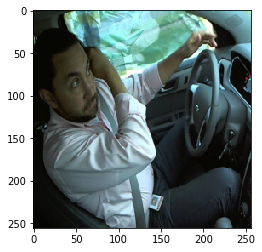

In [101]:
i = 1
plt.imshow(np.array(next(pseudolabel_batches)[0][i]).astype(np.uint8).transpose((1,2,0)))
print(np.argmax(next(pseudolabel_batches)[1][i]))
print(next(pseudolabel_batches)[1][i])

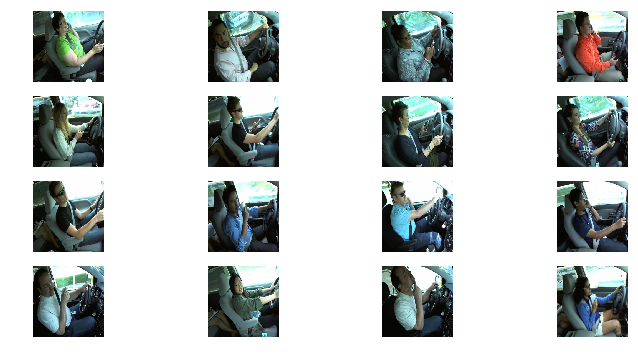

In [47]:
#plots(next(batches)[0], rows=4)
plots(next(pseudolabel_batches)[0], rows=4)

In [10]:
batches.n, pseudolabel_batches.n, batches.batch_size, pseudolabel_batches.batch_size

(17940, 79726, 48, 16)

In [11]:
mix_pseudolabel_batches = MixIterator([batches, pseudolabel_batches])

In [12]:
mix_pseudolabel_batches.n, mix_pseudolabel_batches.batch_size, mix_pseudolabel_batches.steps_per_epoch

(97666, 64, 4983)

#### Model Tuning

In [16]:
model.fit_generator(mix_pseudolabel_batches, steps_per_epoch=mix_pseudolabel_batches.steps_per_epoch, 
                    epochs=2, verbose=2,
                    validation_data=val_batches, validation_steps=ceil(val_batches.n/val_batches.batch_size))

Epoch 1/2
 - 6223s - loss: 2.1480 - acc: 0.3915 - val_loss: 3.0645 - val_acc: 0.7890
Epoch 2/2
 - 6051s - loss: 1.7109 - acc: 0.4407 - val_loss: 3.0413 - val_acc: 0.7509


In [17]:
model_name = 'Vgg16BN-ted'
sub_model_name = ''
model.save_weights(model_path + model_name + '_dropout1_pseudolabel1.h5')

In [13]:
model_name = 'Vgg16BN-ted'
sub_model_name = ''
model.load_weights(model_path + model_name + '_dropout1_pseudolabel1.h5')

In [14]:
model.lr = 1

In [15]:
model.fit_generator(mix_pseudolabel_batches, steps_per_epoch=mix_pseudolabel_batches.steps_per_epoch, 
                    epochs=5, verbose=2,
                    validation_data=val_batches, validation_steps=ceil(val_batches.n/val_batches.batch_size))

Epoch 1/5
 - 6184s - loss: 1.7051 - acc: 0.4458 - val_loss: 2.9665 - val_acc: 0.7489
Epoch 2/5
 - 6011s - loss: 1.6987 - acc: 0.4467 - val_loss: 3.8156 - val_acc: 0.6905
Epoch 3/5


KeyboardInterrupt: 

In [ ]:
model_name = 'Vgg16BN-ted'
sub_model_name = ''
model.save_weights(model_path + model_name + '_dropout1_pseudolabel1.h5')

In [ ]:
model_name = 'Vgg16BN-ted'
sub_model_name = ''
model.load_weights(model_path + model_name + '_dropout1_pseudolabel1.h5')

In [ ]:
model.fit_generator(mix_pseudolabel_batches, steps_per_epoch=mix_pseudolabel_batches.steps_per_epoch, 
                    epochs=5, verbose=2,
                    validation_data=val_batches, validation_steps=ceil(val_batches.n/val_batches.batch_size))

In [ ]:
model.fit_generator(mix_pseudolabel_batches, steps_per_epoch=mix_pseudolabel_batches.steps_per_epoch, 
                    epochs=5, verbose=2,
                    validation_data=val_batches, validation_steps=ceil(val_batches.n/val_batches.batch_size))